# Load

In [687]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import data_preprocesing_helpers as dp
import data_explorer as de


import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression as log_reg
from sklearn.tree import DecisionTreeClassifier as dtree
from sklearn.ensemble import RandomForestClassifier as rf

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import auc, classification_report, RocCurveDisplay

import statsmodels.api as sm

def scale_x(x, xval):
    scaler = StandardScaler()
    scaler.fit(x)
    x_scaled = pd.DataFrame(scaler.transform(x), columns = scaler.feature_names_in_, index = x.index)
    xval_scaled = pd.DataFrame(scaler.transform(xval), columns = scaler.feature_names_in_, index = xval.index)
    return x_scaled, xval_scaled


def evaluate_predictions(actuals, preds, probs = None):
    
    preds_df = pd.DataFrame(preds, columns = {'predictions'}, index = actuals.index)
    preds_df['actuals'] = actuals
    preds_df['probs'] = probs
    preds_df['error'] = actuals == preds
    
    report = classification_report(actuals, preds, output_dict = True)
    actuals = yval
    acc = accuracy_score(actuals, preds)
    precision = precision_score(actuals, preds)
    recall = recall_score(actuals, preds)
    f1 = f1_score(actuals, preds)
    roc_auc = roc_auc_score(actuals, preds)

    errors = [acc, roc_auc, precision, recall, f1]
    
    print(f'Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}')
    

    fpr, tpr, thresholds = roc_curve(yval, probs)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    
    return report, errors, preds_df

"""
def evaluate_predictions(preds, actuals):
    
    # DF
    preds_df = pd.DataFrame(preds, columns = {'predictions'}, index = actuals.index)
    preds_df['actuals'] = actuals
    preds_df['error'] = actuals == preds
    
    # Confustion Matrix
    pd.crosstab(actuals, preds)
    
    # ROC Curve, ROC Metric
    
    # Errors
    
    errors = [mape, mae, rmsle, r2]
    
    print(f'MAPE is: {mape}, MAE is : {mae}, RMSLE : {rmsle}, r2: {r2}')
    
    return errors, preds_df
"""


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


"\ndef evaluate_predictions(preds, actuals):\n    \n    # DF\n    preds_df = pd.DataFrame(preds, columns = {'predictions'}, index = actuals.index)\n    preds_df['actuals'] = actuals\n    preds_df['error'] = actuals == preds\n    \n    # Confustion Matrix\n    pd.crosstab(actuals, preds)\n    \n    # ROC Curve, ROC Metric\n    \n    # Errors\n    \n    errors = [mape, mae, rmsle, r2]\n    \n    print(f'MAPE is: {mape}, MAE is : {mae}, RMSLE : {rmsle}, r2: {r2}')\n    \n    return errors, preds_df\n"

In [688]:
#df = dp.get_preprocessed_data()
df = dp.get_preprocessed_data(ohe=False)

Loading ./churn_prediction.csv
Data has (28382, 20) shape


In [502]:
df

,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,current_balance,...,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,balance_ratio,debit_ratio,credit_ratio,age_group,liquid_ratio
customer_id,,,,,,,,,,,,,,,,,,,,,
1,3135,66,Male,0.0,self_employed,187,2,755,224.0,1458.71,...,0.20,0.20,1458.71,1458.71,False,1.000000,1.000000,1.000000,"(60, 100]","(-1, 0]"
2,310,35,Male,0.0,self_employed,na,2,3214,60.0,5390.37,...,5486.27,100.56,6496.78,8787.61,False,0.746357,54.557180,1.000000,"(30, 60]","(0, 1]"
4,2356,31,Male,0.0,salaried,146,2,41,999.0,3913.16,...,6046.73,259.23,5006.28,5070.14,False,0.860882,23.325734,1.000000,"(30, 60]","(0, 1]"
5,478,90,na,0.0,self_employed,1020,2,582,147.0,2291.91,...,0.47,2143.33,2291.91,1669.79,True,1.000000,0.000219,1.000000,"(60, 100]","(-1, 0]"
6,2531,42,Male,2.0,self_employed,1494,3,388,58.0,927.72,...,588.62,1538.06,1157.15,1677.16,True,0.825522,0.382703,0.000462,"(30, 60]","(-1, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30297,1845,10,Female,0.0,student,1020,2,1207,70.0,1076.43,...,0.30,0.30,1076.43,1076.43,False,1.000000,1.000000,1.000000,"(0, 18]","(-1, 0]"
30298,4919,34,Female,0.0,self_employed,1046,2,223,14.0,3844.10,...,901.00,1014.07,3738.54,3690.32,False,0.918739,0.888499,0.746725,"(30, 60]","(-1, 0]"
30299,297,47,Male,0.0,salaried,1096,2,588,0.0,65511.97,...,168.23,71.80,61078.50,57564.24,True,1.000999,2.343036,1.201846,"(30, 60]","(-1, 0]"


# Explore Models

In [550]:
select_cols = ['occupation', #'customer_nw_category', 
               'days_since_last_transaction', 'liquid_ratio',
               'current_balance', 'previous_month_end_balance',
              'average_monthly_balance_prevQ', 'average_monthly_balance_prevQ2',
              'current_month_credit', 'current_month_debit', 'previous_month_credit', 'previous_month_debit']
x,y,xval,yval = dp.split_data(df, target = 'churn', include_cols=select_cols, validation_split=0.25, ohe = True)
x,xval = scale_x(x,xval)

input data has 28382 rows
Subsetting Columns
One Hot Encoding
output data has 21286 + 7096 rows


## Random Prediction

In [537]:
base_pred = [1 if x == 1 else 0 for x in xval['occupation_student']]
pd.crosstab(base_pred, yval)

churn,False,True
row_0,,
0,5781,1315


Accuracy: 0.814684329199549, Precision: 0.0, Recall: 0.0, F1: 0.0


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

({'False': {'precision': 0.814684329199549,
   'recall': 1.0,
   'f1-score': 0.8978799409800419,
   'support': 5781},
  'True': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1315},
  'accuracy': 0.814684329199549,
  'macro avg': {'precision': 0.4073421645997745,
   'recall': 0.5,
   'f1-score': 0.44893997049002093,
   'support': 7096},
  'weighted avg': {'precision': 0.6637105562433192,
   'recall': 0.814684329199549,
   'f1-score': 0.7314887174190562,
   'support': 7096}},
 [0.814684329199549, 0.5, 0.0, 0.0, 0.0])

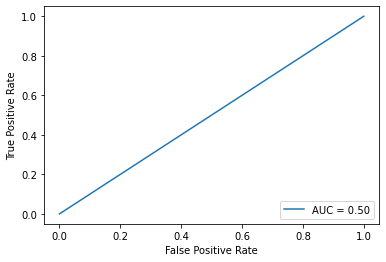

In [538]:
evaluate_prediction(yval, base_pred, base_pred)

## Logistic Regression

In [539]:
model = log_reg()
model.fit(x,y)
model.score(x,y), model.score(xval, yval)

(0.8257070374894296, 0.8244081172491544)

In [540]:
preds = model.predict(xval)
probs = model.predict_proba(xval)

Accuracy: 0.8244081172491544, Precision: 0.6927374301675978, Recall: 0.09429657794676806, F1: 0.16599732262382866


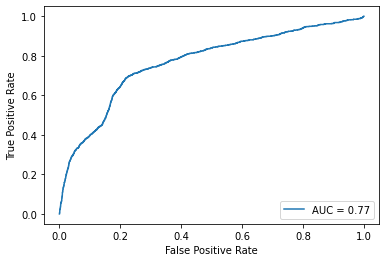

In [541]:
report, errors, preds_lr = evaluate_predictions(yval, preds, probs[:,1])

In [542]:
cm = metrics.confusion_matrix(yval, preds)
disp = metrics. ConfusionMatrixDisplay(confusion_matrix=cm)

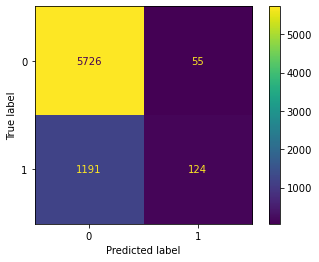

In [543]:
disp.plot()

In [544]:
#model.feature_names_in_, model.coef_
coef_df = pd.DataFrame(model.coef_[0], index = list(model.feature_names_in_), 
                       columns = ['coefficient']).sort_values('coefficient', ascending=False)
coef_df

,coefficient
average_monthly_balance_prevQ,4.620720
previous_month_debit,0.185274
"liquid_ratio_(0, 1]",0.164934
"liquid_ratio_(2, 100]",0.130074
previous_month_end_balance,0.127533
"liquid_ratio_(1, 2]",0.101046
average_monthly_balance_prevQ2,0.094839
occupation_self_employed,0.044956
occupation_student,0.017505
"liquid_ratio_(-100000, -2]",0.000000


## StatsModel

In [590]:
# building the model and fitting the data
x['intercept'] = 1
sm_reg = sm.Logit(y, x).fit(method='bfgs')
sm_reg

         Current function value: 0.431927
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [591]:
print(sm_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                25543
Model:                          Logit   Df Residuals:                    25521
Method:                           MLE   Df Model:                           21
Date:                Thu, 23 Feb 2023   Pseudo R-squ.:                 0.09900
Time:                        02:40:50   Log-Likelihood:                -11033.
converged:                      False   LL-Null:                       -12245.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
days_since_last_transaction       -0.2086        nan        nan        nan         nan         nan
vintage                           -0.1939        nan        nan        

## Expand Model

In [592]:
select_cols = ['age_group','days_since_last_transaction','vintage','dependents',
               'current_balance', 'previous_month_end_balance','liquid_ratio',
              'average_monthly_balance_prevQ', 'average_monthly_balance_prevQ2',
              'current_month_credit', 'current_month_debit', 
               'previous_month_credit', 'previous_month_debit', 'credit_ratio']
x,y,xval,yval = dp.split_data(df, target = 'churn', include_cols=select_cols, validation_split=0.1, ohe = True)
x,xval = scale_x(x,xval)

input data has 28382 rows
Subsetting Columns
One Hot Encoding
output data has 25543 + 2839 rows


Accuracy: 0.8221204649524481, Precision: 0.647887323943662, Recall: 0.08745247148288973, F1: 0.15410385259631493


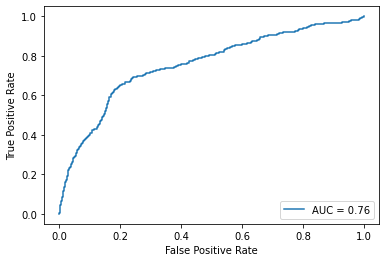

In [593]:
model = log_reg()
model.fit(x,y)
model.score(x,y), model.score(xval, yval)
preds = model.predict(xval)
probs = model.predict_proba(xval)
report, errors, preds_lr2 = evaluate_predictions(yval,preds, probs[:,1])

In [594]:
# building the model and fitting the data
x_sm = x.copy()
x_sm['intercept'] = 1
y = 1*y
sm_reg = sm.Logit(y, x_sm).fit(method='bfgs')
print(sm_reg.summary())

         Current function value: 0.431927
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                25543
Model:                          Logit   Df Residuals:                    25521
Method:                           MLE   Df Model:                           21
Date:                Thu, 23 Feb 2023   Pseudo R-squ.:                 0.09900
Time:                        02:41:19   Log-Likelihood:                -11033.
converged:                      False   LL-Null:                       -12245.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
days_since_last_transaction       -0

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Accuracy: 0.8474815075730892, Precision: 0.628808864265928, Recall: 0.43155893536121676, F1: 0.5118376550169109


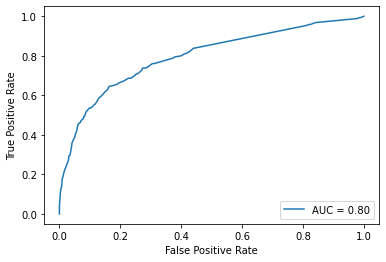

In [621]:
model = dtree(max_depth=10, max_features=100, min_samples_leaf=100)
model.fit(x,y)
preds_dt = model.predict(xval)
probs_dt = model.predict_proba(xval)

report_dt, errors_dt, pred_dt = evaluate_predictions(yval, preds_dt, probs_dt[:,1])

# Dtree Grid Search

In [415]:
param_grid = {'max_features' : [1,10,100], 'max_depth': [1,10,100]}
x,y = dp.split_data(df, target = 'churn', include_cols=select_cols, ohe = True)
x, _ = scale_x(x,x)

gcv = GridSearchCV(dtree(), param_grid, scoring = 'f1', verbose = 3)
gcv.fit(x,y)

input data has 28382 rows
Subsetting Columns
One Hot Encoding
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .......max_depth=1, max_features=1;, score=0.000 total time=   0.0s
[CV 2/5] END .......max_depth=1, max_features=1;, score=0.000 total time=   0.0s
[CV 3/5] END .......max_depth=1, max_features=1;, score=0.000 total time=   0.0s
[CV 4/5] END .......max_depth=1, max_features=1;, score=0.000 total time=   0.0s
[CV 5/5] END .......max_depth=1, max_features=1;, score=0.000 total time=   0.0s
[CV 1/5] END ......max_depth=1, max_features=10;, score=0.000 total time=   0.0s
[CV 2/5] END ......max_depth=1, max_features=10;, score=0.486 total time=   0.0s
[CV 3/5] END ......max_depth=1, max_features=10;, score=0.000 total time=   0.0s
[CV 4/5] END ......max_depth=1, max_features=10;, score=0.000 total time=   0.0s
[CV 5/5] END ......max_depth=1, max_features=10;, score=0.496 total time=   0.0s
[CV 1/5] END .....max_depth=1, max_features=100;, score=0.507 total 

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 10, 100],
                         'max_features': [1, 10, 100]},
             scoring='f1', verbose=3)

## RF Grid Search

In [486]:
param_grid = {'max_features' : [1,10,100], 'max_depth': [1,10,100, None]}
x,y = dp.split_data(df, target = 'churn', include_cols=select_cols, ohe = True)
x, _ = scale_x(x,x)

gcv = GridSearchCV(rf(), param_grid, scoring = 'f1', verbose = 3)
gcv.fit(x,y)

input data has 28382 rows
Subsetting Columns
One Hot Encoding
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .......max_depth=1, max_features=1;, score=0.000 total time=   0.2s
[CV 2/5] END .......max_depth=1, max_features=1;, score=0.000 total time=   0.2s
[CV 3/5] END .......max_depth=1, max_features=1;, score=0.000 total time=   0.2s
[CV 4/5] END .......max_depth=1, max_features=1;, score=0.000 total time=   0.2s
[CV 5/5] END .......max_depth=1, max_features=1;, score=0.000 total time=   0.2s
[CV 1/5] END ......max_depth=1, max_features=10;, score=0.038 total time=   0.8s
[CV 2/5] END ......max_depth=1, max_features=10;, score=0.013 total time=   0.8s
[CV 3/5] END ......max_depth=1, max_features=10;, score=0.087 total time=   0.8s
[CV 4/5] END ......max_depth=1, max_features=10;, score=0.056 total time=   0.8s
[CV 5/5] END ......max_depth=1, max_features=10;, score=0.052 total time=   0.8s
[CV 1/5] END .....max_depth=1, max_features=100;, score=0.501 total

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 10, 100, None],
                         'max_features': [1, 10, 100]},
             scoring='f1', verbose=3)

In [488]:
gcv.best_estimator_

RandomForestClassifier(max_depth=100, max_features=10)

Loading from customer_churn folder
input data has 28382 rows
Subsetting Columns
One Hot Encoding
output data has 25543 + 2839 rows
Accuracy: 0.8555829517435717, Precision: 0.6611111111111111, Recall: 0.4524714828897338, F1: 0.5372460496613995


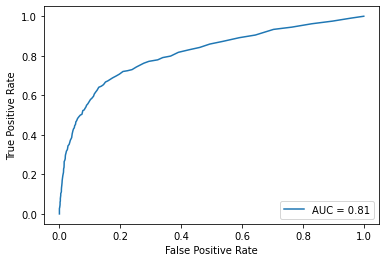

In [498]:
x,y,xval,yval = dp.split_data(df, target = 'churn', include_cols=select_cols, validation_split=0.1, ohe = True)
x,xval = scale_x(x,xval)

model = rf(max_depth=100, max_features=10)
model.fit(x,y)

preds_rf = model.predict(xval)
probs_rf = model.predict_proba(xval)

report_rf, errors_rf, preds_rf = evaluate_predictions(yval, preds_rf, probs_rf[:,1])

# feature Selection

## Dtree

In [393]:
from sklearn.feature_selection import RFECV

x,y = dp.split_data(df, target = 'churn', include_cols=select_cols, ohe = True)
x, _ = scale_x(x,x)


input data has 28382 rows
Subsetting Columns
One Hot Encoding


In [421]:
rfe = RFECV(dtree(max_depth=10, max_features=100), scoring = 'f1', verbose = 2)
rfe.fit(x,y)

Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitt

RFECV(estimator=DecisionTreeClassifier(max_depth=10, max_features=100),
      scoring='f1', verbose=2)

In [423]:
feature_ranks = pd.DataFrame(rfe.ranking_, columns = ['feat_rank'], index = rfe.feature_names_in_)
feature_ranks

,feat_rank
days_since_last_transaction,9
vintage,7
dependents,11
current_balance,1
previous_month_end_balance,6
average_monthly_balance_prevQ,1
average_monthly_balance_prevQ2,4
current_month_credit,5
current_month_debit,2
previous_month_credit,8


In [479]:
select_cols = feature_ranks[feature_ranks.feat_rank <= 15].index
select_cols

select_cols = ['days_since_last_transaction', 'vintage', 'dependents',
       'current_balance', 'previous_month_end_balance',
       'average_monthly_balance_prevQ', 'average_monthly_balance_prevQ2',
       'current_month_credit', 'current_month_debit', 'previous_month_credit',
       'previous_month_debit', 'credit_ratio', 'age_group']
       
       

In [480]:
x,y,xval,yval = dp.split_data(df, target = 'churn', include_cols=select_cols, validation_split=0.1, ohe = True)
x,xval = scale_x(x,xval)

input data has 28382 rows
Subsetting Columns
One Hot Encoding
output data has 25543 + 2839 rows


Accuracy: 0.8534695315251849, Precision: 0.6314363143631436, Recall: 0.45419103313840153, F1: 0.528344671201814


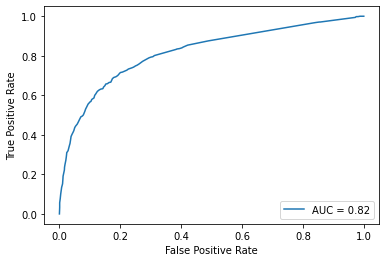

In [481]:
model = dtree(max_depth=10, max_features=100, min_samples_leaf=100)
model.fit(x,y)
preds_dt = model.predict(xval)
probs_dt = model.predict_proba(xval)

report_dt, errors_dt, pred_dt = evaluate_predictions(yval, preds_dt, probs_dt[:,1])

## RF

In [492]:
rfe = RFECV(rf(max_depth=100, max_features=10), scoring = 'f1', verbose = 2)
rfe.fit(x,y)

Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitt

RFECV(estimator=RandomForestClassifier(max_depth=100, max_features=10),
      scoring='f1', verbose=2)

In [493]:
feature_ranks = pd.DataFrame(rfe.ranking_, columns = ['feat_rank'], index = rfe.feature_names_in_)
feature_ranks

,feat_rank
days_since_last_transaction,1
vintage,1
dependents,1
current_balance,1
previous_month_end_balance,1
average_monthly_balance_prevQ,1
average_monthly_balance_prevQ2,1
current_month_credit,1
current_month_debit,1
previous_month_credit,1


# Curves

In [494]:
p,r,t = metrics.precision_recall_curve(yval, probs_rf[:,1], )

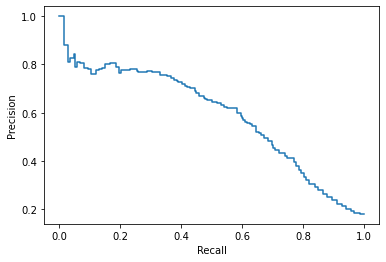

In [495]:
disp = metrics.PrecisionRecallDisplay(p,r)
disp.plot()

In [496]:
fpr, fnr, thresholds = metrics.det_curve(yval, probs_rf[:,1])

<AxesSubplot:>

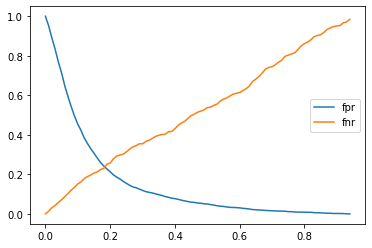

In [497]:
sns.lineplot(x = thresholds, y = fpr, label = 'fpr')
sns.lineplot(x = thresholds, y = fnr, label = 'fnr')

# Upsampling

In [623]:
from sklearn.utils import resample

In [691]:
def upsample_df(df, target):
    target = 'churn'
    df_1 = df[df[target] == 1] 
    df_2 = df[df[target] == 0] 
    ratio = df_2.shape[0]/df_1.shape[0]
    ratio
    df_1_ups = resample(df_1,random_state=42,n_samples=int(ratio*df_1.shape[0]),replace=True)
    df_upsampled = pd.concat([df_1_ups,df_2])
    print(df_upsampled.shape)
    return df_upsampled

In [707]:
select_cols = ['days_since_last_transaction', 'vintage', 'dependents',
       'current_balance', 'previous_month_end_balance',
       'average_monthly_balance_prevQ', 'average_monthly_balance_prevQ2',
       'current_month_credit', 'current_month_debit', 'previous_month_credit',
       'previous_month_debit', 'credit_ratio', 'age_group']
       
       
        
x,y,xval,yval = dp.split_data(df, target = 'churn', 
                              include_cols=select_cols, 
                              validation_split=0.2, ohe = True)
x,xval = scale_x(x,xval)

input data has 28382 rows
Subsetting Columns
One Hot Encoding
output data has 22705 + 5677 rows


In [708]:
#df_upsampled = pd.concat([x,y], axis = 1)
#df_upsampled = upsample_df(df_upsampled, 'churn')
#x,y = dp.split_data(df_upsampled, 'churn')

In [709]:
model = dtree(max_depth=10, max_features=100, min_samples_leaf=100)
model.fit(x,y)
preds = model.predict(xval)
probs = model.predict_proba(xval)

Accuracy: 0.8576713052668663, Precision: 0.6689750692520776, Recall: 0.4591254752851711, F1: 0.5445321307779031


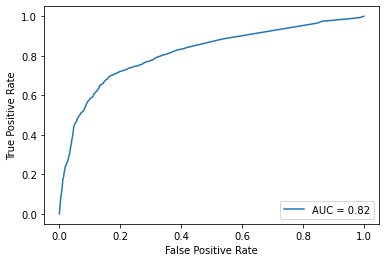

In [710]:
report,errors, preds_df = evaluate_predictions(yval, preds, probs[:,1])